In [1]:
%load_ext autoreload
%autoreload 2
import torch
from models.vgg19style import VGG19Style
from lib.fashionpedia_processed import FashionPediaProcessed
from tqdm.autonotebook import tqdm

C:\Users\gijsa\AppData\Local\Temp\ipykernel_16856\490663410.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# load model
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else device
print(device)

model = VGG19Style().to(device)

cpu


In [3]:
# load dataset
set

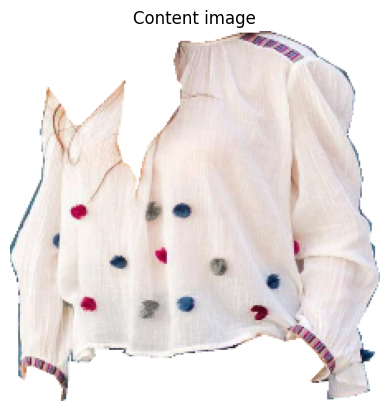

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.])
attributes:
rugby (shirt)
halter (top)
peasant (top)
tube (top)
trucker (jacket)
anorak
mao (jacket)
norfolk (jacket)
chanel (jacket)


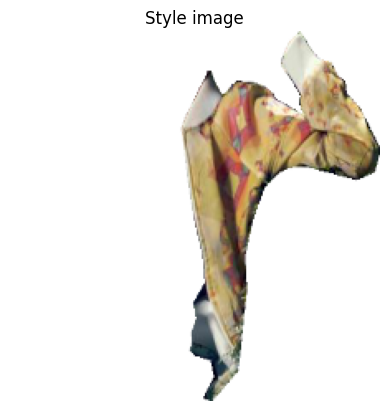

attributes:
classic (t-shirt)
classic (t-shirt)
classic (t-shirt)
classic (t-shirt)
classic (t-shirt)
classic (t-shirt)
polo (shirt)
classic (t-shirt)
polo (shirt)
classic (t-shirt)
classic (t-shirt)
classic (t-shirt)
polo (shirt)
polo (shirt)
classic (t-shirt)
classic (t-shirt)
classic (t-shirt)
classic (t-shirt)
polo (shirt)
classic (t-shirt)
classic (t-shirt)
polo (shirt)
classic (t-shirt)
classic (t-shirt)
classic (t-shirt)
classic (t-shirt)
polo (shirt)
classic (t-shirt)
classic (t-shirt)
classic (t-shirt)
classic (t-shirt)
classic (t-shirt)


In [13]:
import matplotlib.pyplot as plt
import lib.utils as utils
import torchvision.transforms as T

style_data = data[66]
content_data = data[18]

plt.imshow(data.invImg(content_data['img']))
plt.title('Content image')
plt.axis('off')
plt.show()

print('attributes:', *[utils.get_attribute_name(att_id) for att_id in content_data['atts']], sep='\n')

plt.imshow(data.invImg(style_data['img']))
plt.title('Style image')
plt.axis('off')
plt.show()

print('attributes:', *[utils.get_attribute_name(att_id) for att_id in style_data['atts']], sep='\n')

In [7]:
def gram_matrix(tensor: torch.Tensor):
    depth = tensor.shape[0]
    tensor = tensor.view(depth, -1)
    return torch.mm(tensor, tensor.t()) 

In [ ]:
# save the activations of the selected layers

activations = {}
def set_activation(name):
    return lambda _, __, output: activations.update({name: output})

# content layer
model.layers[21].register_forward_hook(set_activation('conv_4_2'))

# style layers
style_layers = {0: 'conv_1_1', 5: 'conv_2_1', 10: 'conv_3_1', 19: 'conv_4_1', 28: 'conv_5_1'}
for i, name in style_layers.items():
    model.layers[i].register_forward_hook(set_activation(name))

# save activations for content and style reference imgs
model(content_data['img'].to(device))
content_img_feature = activations['conv_4_2']

model(style_data['img'].to(device))
style_img_grams = {i: gram_matrix(activations[name]) for i, name in style_layers.items()}

In [ ]:
import torch.nn as nn

def get_content_loss(content_img_feature, target_img_feature):
	return torch.sum((content_img_feature - target_img_feature) ** 2) / 2

In [ ]:
def get_style_loss(style_img_grams, target_img_features):
	loss = 0

	for i in style_layers.keys():
		target_gram = gram_matrix(target_img_features[i])
		squared_err = torch.sum((target_gram - style_img_grams[i]) ** 2)

		_, height, width = target_img_features[i].shape
		loss += squared_err / (4 * height ** 2 * width ** 2)

	return loss / len(style_layers)

### Single image content transfer from noise

In [ ]:
# generate target image
target_img = torch.normal(0, 1, content_data['img'].shape, requires_grad=True, device=device)

In [ ]:
from tqdm.autonotebook import trange

# gaussian noise image
optimizer = torch.optim.Adam([target_img], lr=0.001)
iterations = 50000

for i in trange(iterations + 1):
    optimizer.zero_grad()

    model(target_img)

    target_content_feature = activations['conv_4_2']

    content_loss = get_content_loss(content_img_feature, target_content_feature)

    content_loss.backward()
    optimizer.step()

    if i % 10000 == 0:
        plt.title(f'Content, iteration: {i}, Loss: {content_loss.item()}')
        plt.imshow(target_img.cpu().detach().permute(1, 2, 0))
        plt.axis('off')
        plt.savefig(f'blog/imgs/noise_content/{i}')
        plt.show()

### Single image style transfer from noise

In [ ]:
target_img = torch.normal(0, 1, content_data['img'].shape, requires_grad=True, device=device)

In [ ]:
from tqdm.autonotebook import trange

optimizer = torch.optim.Adam([target_img], lr=0.001)
iterations = 50000

for i in trange(iterations + 1):
    optimizer.zero_grad()

    model(target_img)

    target_style_features = {i: activations[name] for i, name in style_layers.items()}

    style_loss = get_style_loss(style_img_grams, target_style_features)

    style_loss.backward()
    optimizer.step()

    if i % 10000 == 0:
        plt.title(f'Style, iteration: {i}, loss: {round(style_loss.item(), 4)}')
        plt.imshow(target_img.cpu().detach().permute(1, 2, 0))
        plt.axis('off')
        plt.savefig(f'blog/imgs/style_content/{i}')
        plt.show()

### General style transfer on a content image

By using multiple images with the same style might generalize a style on the content image

Number of style images: 0


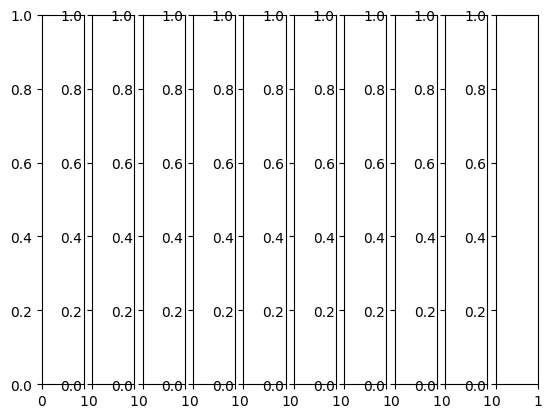

In [9]:
# Get all images with certain style 

# selected_att = 322 # checkered
# selected_att = 321 # camouflage
selected_att = 325 # floral

style_images = []
for i, d in enumerate(data): 
	if selected_att in d['att_oh']:
		style_images.append(d['img'])

print(f'Number of style images: {len(style_images)}')
fig, axes = plt.subplots(1, 10)
# axes[2].set_title(f'Style images: {utils.get_attribute_name(selected_att)}')

for i, img in enumerate(style_images[:10]):
	axes[i].imshow(data.invImg(img))
	axes[i].axis('off')

plt.show()

In [ ]:
# Set content and style image features
content_image = content_data['img']

model(content_image.to(device))

content_img_feature = activations['conv_4_2']

style_images_grams = []

for style_image in tqdm(style_images):
	model(style_image.to(device))

	style_images_grams.append({i: gram_matrix(activations[name]) for i, name in style_layers.items()})


In [ ]:
from tqdm.autonotebook import trange

# Set constants
ALPHA_BETA = 1e-3
ITERATIONS = 3000
LR = 1e-3

target_img = torch.tensor(content_image, device=device, requires_grad=True)

# Set optimizer
optimizer = torch.optim.Adam([target_img], lr=LR)

for i in trange(ITERATIONS):

    for style_img_gram in style_images_grams[:10]:
        optimizer.zero_grad()

        model(target_img)

        target_content_feature = activations['conv_4_2']

        content_loss = get_content_loss(content_img_feature, target_content_feature)

        target_style_features = {k: activations[name] for k, name in style_layers.items()}

        style_loss = get_style_loss(style_img_gram, target_style_features)

        total_loss = ALPHA_BETA * content_loss + style_loss

        total_loss.backward()
        optimizer.step()

    if i % 100 == 0:
        plt.title(f'Iterations: {i}, Loss: {total_loss.item()}')
        plt.imshow(data.invImg(target_img.cpu().detach()))
        plt.axis('off')
        plt.savefig(f'blog/imgs/multi/{i}', bbox_inches='tight')
        plt.show()

### General style transfer on a content image

By using a single style image on a content image

In [ ]:
# use this to find images in the dataset

fig, axes = plt.subplots(1, 5)

for i, img in enumerate(data[940:][:5]):
	axes[i].imshow(data.invImg(img['img']))
	axes[i].axis('off')

plt.show()

In [ ]:
import os

# Set content and style image features
os.mkdir(f'blog/imgs/test')
content_data = data[97]
style_data = data[321]

plt.imshow(data.invImg(content_data['img']))
plt.title('Content image')
plt.axis('off')
plt.show()

print('attributes:', *[utils.get_attribute_name(att_id) for att_id in content_data['atts']], sep='\n')

plt.imshow(data.invImg(style_data['img']))
plt.title('Style image')
plt.axis('off')
plt.savefig(f'blog/imgs/test/style', bbox_inches='tight')
plt.show()

print('attributes:', *[utils.get_attribute_name(att_id) for att_id in style_data['atts']], sep='\n')

# save activations for content and style reference imgs
model(content_data['img'].to(device))
content_img_feature = activations['conv_4_2']

model(style_data['img'].to(device))
style_img_grams = {i: gram_matrix(activations[name]) for i, name in style_layers.items()}

In [ ]:
# Set constants
ALPHA_BETA = 1e-3
ITERATIONS = 10000
LR = 1e-3

# Set target image
target_img = torch.tensor(content_data['img'], device=device, requires_grad=True)

# Set optimizer
optimizer = torch.optim.Adam([target_img], lr=LR)

In [ ]:
from tqdm.autonotebook import trange

for i in trange(ITERATIONS + 1):
    optimizer.zero_grad()

    model(target_img)

    target_content_feature = activations['conv_4_2']

    content_loss = get_content_loss(content_img_feature, target_content_feature)

    target_style_features = {k: activations[name] for k, name in style_layers.items()}

    style_loss = get_style_loss(style_img_grams, target_style_features)

    total_loss = ALPHA_BETA * content_loss + style_loss

    total_loss.backward()
    optimizer.step()

    if i % 5000 == 0:
        plt.imshow(data.invImg(target_img.cpu().detach()))
        plt.axis('off')
        plt.title(f'Transfer, iteration: {i}, loss: {round(total_loss.item(), 4)}')
        plt.savefig(f'blog/imgs/test/{i}', bbox_inches='tight')
        plt.show()

In [ ]:
import torchvision.transforms as T
from PIL import Image, ImageDraw
import IPython.display

ann = utils.get_by_id('annotations', content_data['ann_id'])
src_img = utils.get_by_id('images', ann['image_id'])
file_name = src_img['file_name']

x, y, width, height = map(int, ann['bbox'])

res_img = T.Compose([
    data.inv_normal,
    T.Resize((height, width), antialias=True, interpolation=T.InterpolationMode.NEAREST),
    lambda x: torch.clamp(x, 0, 1),
    T.ToPILImage(),
])(target_img)

img = Image.open(f'fashionpedia/img/{file_name}').convert('RGB')

mask = Image.new('1', img.size, 0)

seg = ann['segmentation'][0]
points = list(zip(*(iter(seg),) * 2))

ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)

cropped_mask = mask.crop((x, y, x + width, y + height))

res_img.putalpha(cropped_mask)

img.paste(res_img, (x, y), res_img)

plt.imshow(img)
plt.axis('off')
plt.savefig(f'blog/imgs/test/res', bbox_inches='tight')
plt.show()
IPython.display.Image(filename=f'fashionpedia/img/{file_name}', retina=True)